# Ocean Data Challenge :: Air Quality in Catalonia
Examining open data on particulate matter can help improve our understanding of air pollution and inform strategies to reduce it. Data scientists can help researchers and policymakers make informed decisions about mitigating its effects by providing comprehensive analytics and predictive algorithms.

## The plots are presented in the report (report-aqc.pdf)
On the notebook the results are only on 40% of the dataset
### Luca Ordronneau

## Import Librairies

In [1]:
import gc
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.templates.default = "seaborn"

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get the color scale of the seaborn template
colors =  [
    "#4C72B0",
    "#5A67A5",
    "#6A5B9A",
    "#7A508F",
    "#894684",
    "#994079",
    "#DD8452",
    "#D67B4C",
    "#55A868",
    "#4E9F67",
    "#488C66",
    "#417963",
    "#3A6761",
    "#325F5F",
    "#CE7245",
    "#C6683E",
    "#BF5F37",
    "#B85630",
]
len(colors)

18

In [3]:
DATA = '/Users/lucaordronneau/Documents/Projets/Perso/ocean-data-challenge/dataset.csv'

In [4]:
def prepare_data(df):
    cols_hours = ['01h', '02h', '03h', '04h', '05h', '06h', '07h', '08h', '09h', '10h', 
                  '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h',
                  '21h', '22h', '23h', '24h']

    df = df[~(df['UNITATS'] == 'ppm')] # Don't have the molecular weight to convert into µg/m3
    
    # Conversion same unit
    df.loc[df['UNITATS'] == 'mg/m3', cols_hours] *= 1000
    df.loc[df['UNITATS'] == 'ng/m3', cols_hours] /= 1000
    
    df.loc[:, 'UNITATS'] = 'µg/m3'
    
    # Melt dataframe for treatment (series)
    df['DATA'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')

    chunk_size = len(df) // 50
    chunk_list = [pd.melt(df.iloc[i:i+chunk_size], id_vars=['CODI EOI', 'DATA', 'CONTAMINANT', 'TIPUS ESTACIO', 'AREA URBANA', 'MUNICIPI', 'ALTITUD', 'LATITUD', 'LONGITUD'],
                    value_vars=cols_hours, var_name='hour', value_name='value').dropna() for i in range(0, len(df), chunk_size)]
    df = pd.concat(chunk_list, ignore_index=True)

    df['hour']  = df['hour'].str[:-1].astype(int)
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['datetime'] = df['DATA'] + pd.to_timedelta(df['hour'], unit='h')

    # POTENTIAL MEMORY CONSTRAINTS ON C2D
    df['month'] = df['datetime'].dt.month
    df['year']  = df['datetime'].dt.year

    # Fill na with the mean of the hour of the same month and year from the same station (CODI EOI) 
    df['value'].fillna(df.groupby(['CODI EOI', 'CONTAMINANT', 'hour', 'month', 'year'])['value'].transform('mean'), inplace=True)
    df.dropna(inplace=True)
  
    return df

In [5]:
df = pd.read_csv(DATA)

In [6]:
trim_perc = int(len(df) * 0.40) # Take 40% of the dataset
df = prepare_data(df.head(trim_perc))

In [7]:
df.head()

,CODI EOI,DATA,CONTAMINANT,TIPUS ESTACIO,AREA URBANA,MUNICIPI,ALTITUD,LATITUD,LONGITUD,hour,value,datetime,month,year
0,43148003,2023-01-25,PM10,industrial,suburban,Tarragona,39,41.115910,1.191999,1,11.0,2023-01-25 01:00:00,1,2023
1,8137001,2023-01-25,NOX,background,rural,Montseny,693,41.779280,2.358002,1,2.0,2023-01-25 01:00:00,1,2023
2,8124009,2023-01-25,NO,traffic,suburban,Mollet del Vallès,90,41.549183,2.212098,1,49.0,2023-01-25 01:00:00,1,2023
3,8114006,2023-01-25,NO,background,suburban,Martorell,78,41.475384,1.921202,1,9.0,2023-01-25 01:00:00,1,2023
4,8112003,2023-01-25,NO2,background,suburban,Manlleu,460,42.003307,2.287299,1,24.0,2023-01-25 01:00:00,1,2023


In [8]:
df_municipi_type = df[['MUNICIPI', 'AREA URBANA', 'LATITUD', 'LONGITUD']].groupby(['MUNICIPI', 'AREA URBANA'], as_index=False).mean()

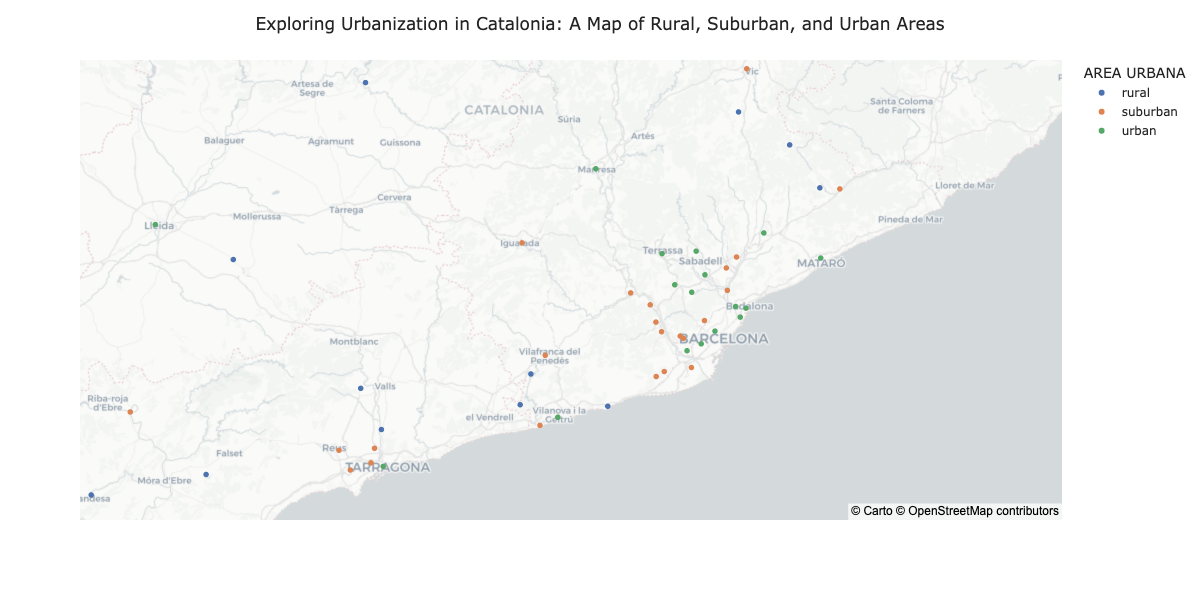

In [9]:
fig = px.scatter_mapbox(df_municipi_type, lat="LATITUD", lon="LONGITUD", hover_name="MUNICIPI", color="AREA URBANA",
                  color_continuous_scale=px.colors.sequential.amp, size_max=20, zoom=8,
                  mapbox_style="carto-positron")
fig.update_layout(title={'text':'Exploring Urbanization in Catalonia: A Map of Rural, Suburban, and Urban Areas'})
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [10]:
del df_municipi_type
gc.collect()

722

### 1. Analyze the evolution of pollution in Catalunya over time to determine the best/worst hours and best/worst months of the year in terms of pollution, and explain the periodicity of the rate of certain pollutants in the air. 

In [11]:
hours = df.groupby(['hour'], as_index=False).mean().sort_values('value', ascending=True)
best_hours = hours.head(5)
worst_hours = hours.tail(5)

months = df.groupby(['month'], as_index=False).mean().sort_values('value', ascending=True)
best_months = months.head(5)
worst_months = months.tail(5)

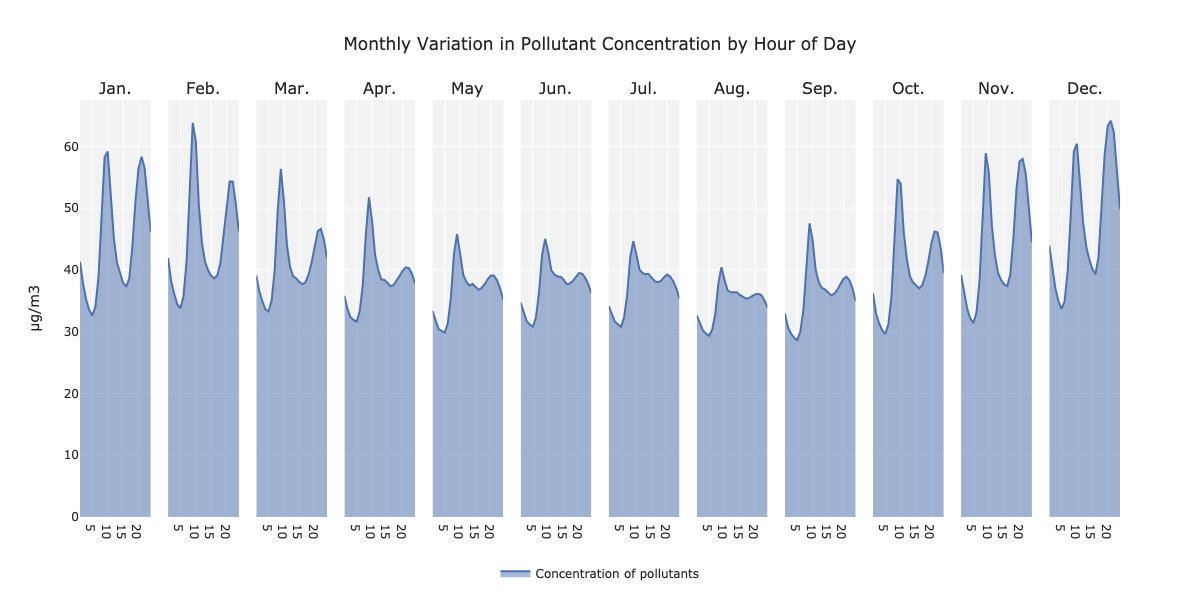

In [12]:
months_str = {1:'Jan.',2:'Feb.',3:'Mar.',4:'Apr.',5:'May',6:'Jun.',7:'Jul.',8:'Aug.',9:'Sep.',10:'Oct.',11:'Nov.',12:'Dec.'}
df_month_hour = df.groupby(['month', 'hour'], as_index=False).mean()
fig = make_subplots(rows=1, cols=12, shared_yaxes=True, subplot_titles=list(months_str.values()))
for key, value in months_str.items():
    df_month = df_month_hour[df_month_hour['month'] == key]
    fig.add_trace(go.Scatter(x=df_month['hour'], y=df_month['value'], name="Concentration of pollutants", legendgroup='g', marker_color='#4C72B0', fill='tozeroy'), row=1, col=key)

names = set()
fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
fig.update_layout(title={'text':'Monthly Variation in Pollutant Concentration by Hour of Day'}, barmode='stack')
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'}, legend = dict(orientation = 'h', xanchor = "center", x = 0.5, y= -0.1))
fig.update_yaxes(title_text='µg/m3', col=1)
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [13]:
print(f"Best hours : {best_hours['hour'].tolist()}")

Best hours : [5, 4, 6, 3, 2]


In [14]:
print(f"Worst hours : {worst_hours['hour'].tolist()}")

Worst hours : [20, 22, 21, 10, 9]


In [15]:
hours_of_interest = sorted(best_hours['hour'].tolist() + worst_hours['hour'].tolist())
hours_of_interest_str = [f"{h}h" for h in hours_of_interest]
hours_of_interest_str

['2h', '3h', '4h', '5h', '6h', '9h', '10h', '20h', '21h', '22h']

In [16]:
print(f"Best months : {best_months['month'].tolist()}")

Best months : [8, 9, 5, 7, 6]


In [17]:
print(f"Worst months : {worst_months['month'].tolist()}")

Worst months : [3, 11, 1, 2, 12]


### 2. Analyze the relationship between altitude and concentration of particles in the air, and present your conclusions in graphical form.

In [18]:
df['ALTITUD'] = df['ALTITUD'].astype(float)
df_contaminant = df.groupby(['CONTAMINANT'], as_index=False).mean()

In [19]:
df_contaminant.head()

,CONTAMINANT,CODI EOI,ALTITUD,LATITUD,LONGITUD,hour,value,month,year
0,C6H6,2.308864e+07,41.298493,41.253552,1.686899,12.506573,0.862112,6.613064,2018.184329
1,CO,1.663400e+07,213.644392,41.462055,1.787481,12.520006,291.501581,6.628677,2017.465918
2,Cl2,4.306000e+07,90.000000,41.229985,0.546944,12.514230,11.804155,6.543416,2016.858659
3,H2S,3.465029e+07,98.257183,41.256803,1.396380,12.504748,1.779412,6.631894,2017.729497
4,Hg,4.306000e+07,90.000000,41.229985,0.546944,12.504792,0.020547,6.646938,2017.770041


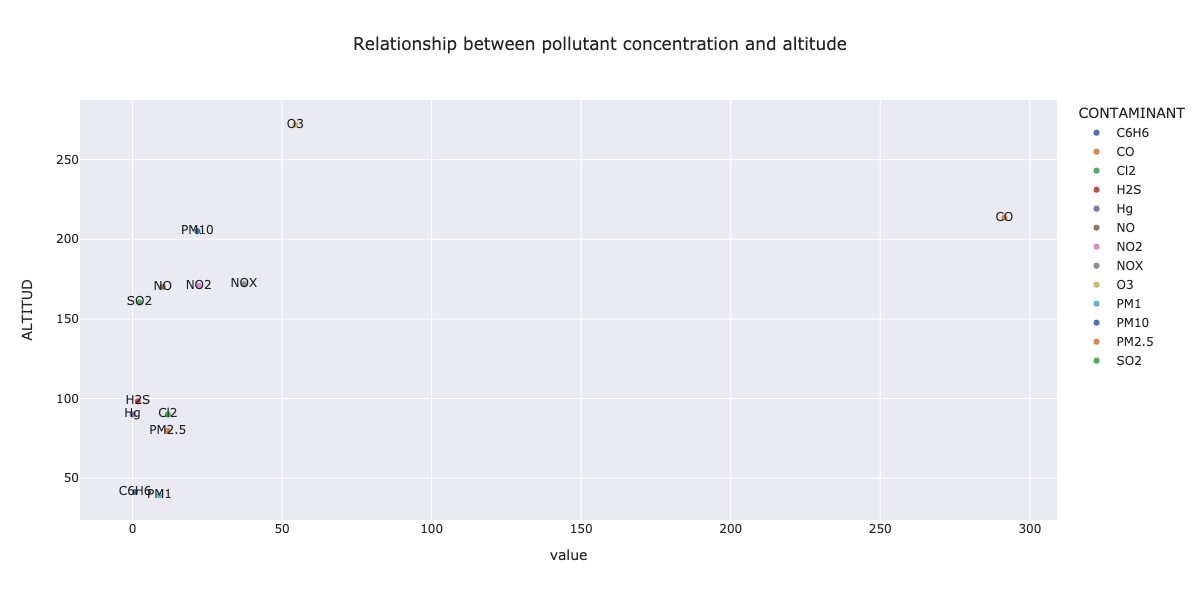

In [20]:
fig = px.scatter(df_contaminant, x="value", y="ALTITUD", color="CONTAMINANT", text="CONTAMINANT", title="Relationship between pollutant concentration and altitude")
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [21]:
df_year_contaminant = df.groupby(['CONTAMINANT', pd.Grouper(key="datetime", freq="YS")]).mean()
df_year_contaminant['datetime'] = df_year_contaminant.index.get_level_values('datetime')
df_year_contaminant['CONTAMINANT'] = df_year_contaminant.index.get_level_values('CONTAMINANT')
df_year_contaminant = df_year_contaminant.reset_index(drop=True)

In [22]:
len(df_year_contaminant)

141

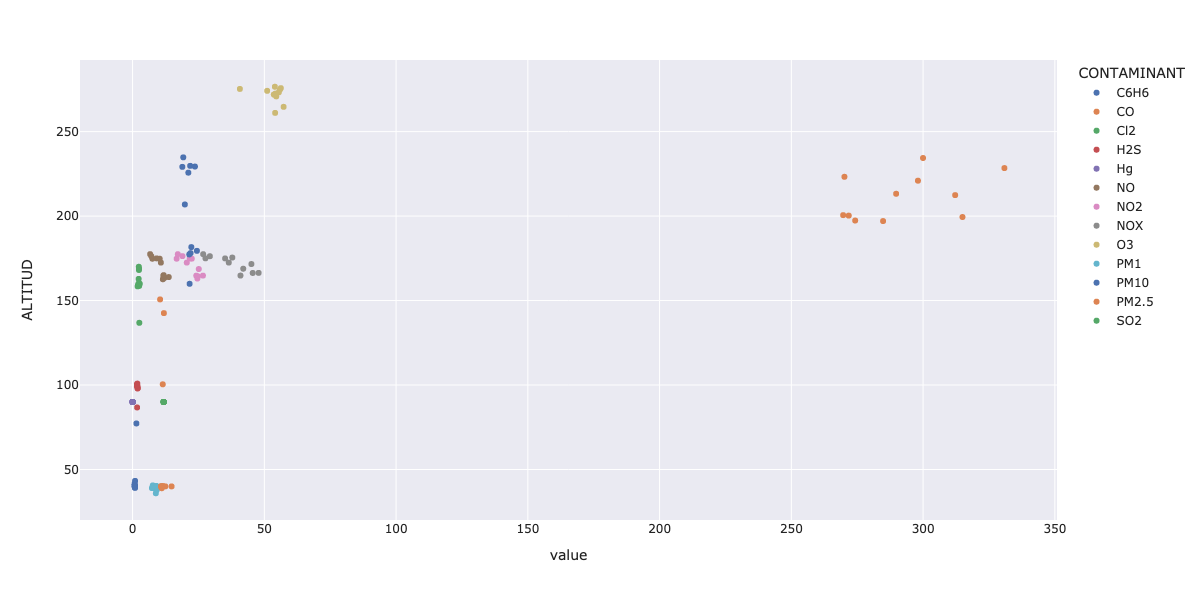

In [23]:
fig = px.scatter(df_year_contaminant, x="value", y="ALTITUD", color="CONTAMINANT")
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

### 3. Analyze the concentration of pollutants in urban, suburban and rural areas, and present your conclusion in graphical form.

In [24]:
df_area = df.groupby(['AREA URBANA'], as_index=False).mean().sort_values('value', ascending=False)

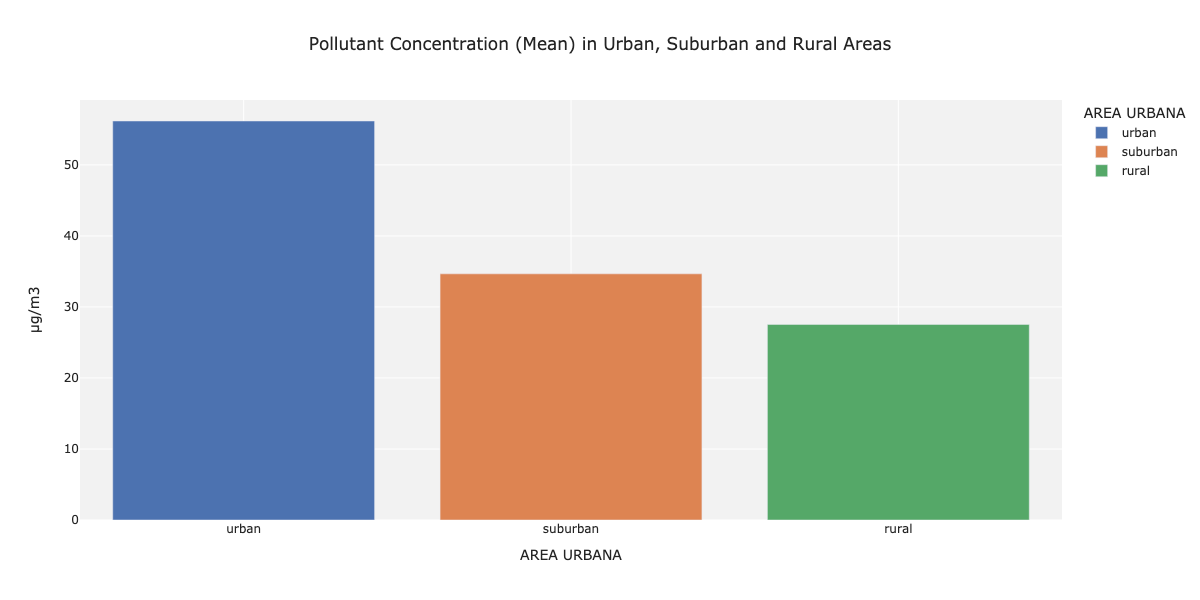

In [25]:
fig = px.bar(df_area, x="AREA URBANA", y="value", color="AREA URBANA", title="Pollutant Concentration (Mean) in Urban, Suburban and Rural Areas")
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)', 'height':500})
fig.update_yaxes(title_text='µg/m3', col=1)
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [26]:
df_area_contaminant = df.groupby(['AREA URBANA', 'CONTAMINANT'], as_index=False).mean().sort_values('value', ascending=False)

In [27]:
df_area_contaminant.head()

,AREA URBANA,CONTAMINANT,CODI EOI,ALTITUD,LATITUD,LONGITUD,hour,value,month,year
23,urban,CO,1.394160e+07,89.983842,41.487898,1.949702,12.525565,328.145435,6.644062,2017.523153
11,suburban,CO,1.288010e+07,123.366751,41.411018,1.847663,12.520205,297.306296,6.610458,2017.523484
1,rural,CO,3.047571e+07,698.592783,41.489043,1.258250,12.505290,186.254957,6.622412,2017.212489
6,rural,O3,2.441771e+07,551.328923,41.774620,1.635620,12.504322,65.039161,6.628054,2017.772952
27,urban,NOX,1.090823e+07,80.280593,41.476380,2.059335,12.501006,51.854062,6.618593,2017.726919


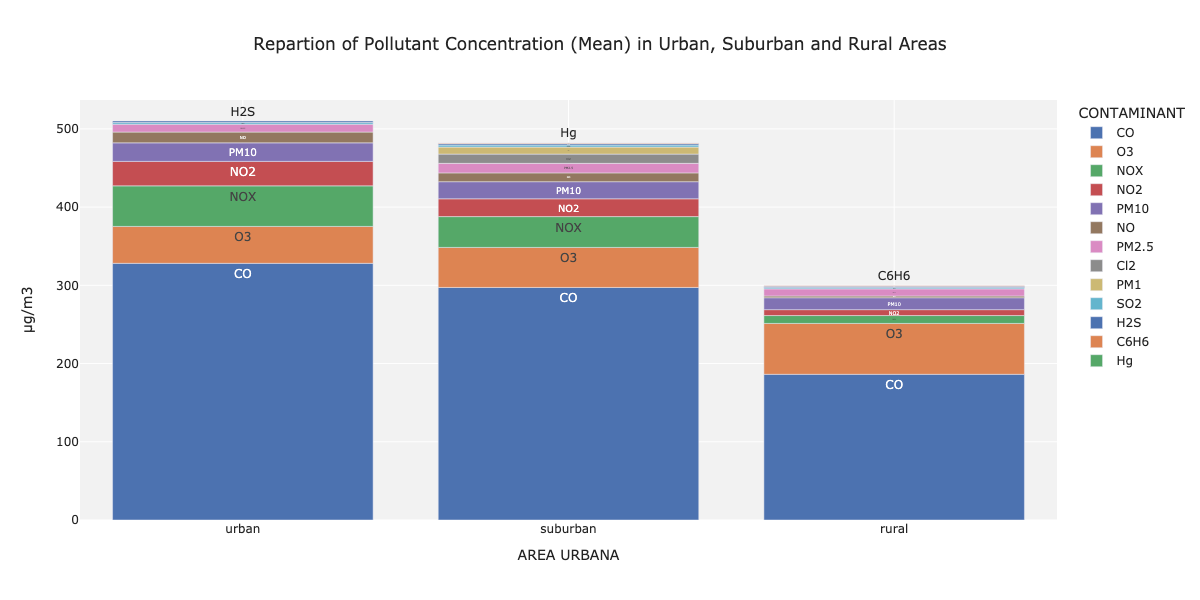

In [28]:
fig = px.bar(df_area_contaminant, x="AREA URBANA", y="value", color="CONTAMINANT", text="CONTAMINANT", title="Repartion of Pollutant Concentration (Mean) in Urban, Suburban and Rural Areas")
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)', 'height':500})
fig.update_yaxes(title_text='µg/m3', col=1)
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [29]:
del df_area_contaminant
gc.collect()

5017

In [30]:
dict_colors = dict(zip(df['CONTAMINANT'].unique().tolist(), colors[:len(df['CONTAMINANT'].unique().tolist())]))

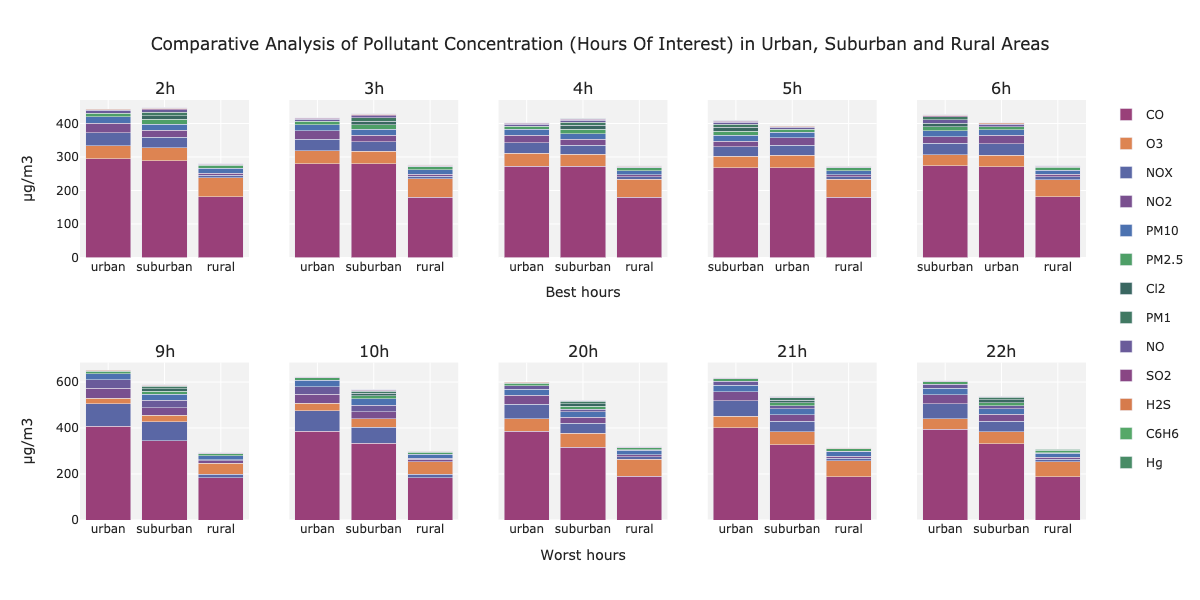

In [31]:
nrows = 2
ncols = 5
fig = make_subplots(rows=nrows, cols=ncols, shared_yaxes=True, subplot_titles=hours_of_interest_str)

df_area_by_hours = df.groupby(['AREA URBANA', 'CONTAMINANT', 'hour'], as_index=False).mean().sort_values('value', ascending=False)

for i, h in enumerate(hours_of_interest):
    row = i // ncols + 1
    col = i % ncols + 1
    df_area_subset_hour = df_area_by_hours[df_area_by_hours['hour'] == h]

    # df_grouped = df_area_subset_hour.groupby(['AREA URBANA', 'CONTAMINANT']).mean().reset_index().sort_values('value', ascending=False)

    for cont in df_area_subset_hour['CONTAMINANT'].unique():
        df_cont = df_area_subset_hour[df_area_subset_hour['CONTAMINANT'] == cont]
        fig.add_trace(go.Bar(x=df_cont['AREA URBANA'], y=df_cont['value'], name=cont, legendgroup=cont, marker_color=dict_colors[cont]), row=row, col=col)
    
names = set()
fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
fig.update_layout(title={'text':'Comparative Analysis of Pollutant Concentration (Hours Of Interest) in Urban, Suburban and Rural Areas'}, barmode='stack')
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'})
fig.update_yaxes(title_text='µg/m3', col=1)
fig.update_xaxes(title_text='Best hours', row=1, col=3)
fig.update_xaxes(title_text='Worst hours', row=2, col=3)
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [32]:
del df_area_by_hours
gc.collect()

950

In [33]:
df_area_tipus_estacio = df.groupby(['AREA URBANA', "TIPUS ESTACIO"], as_index=False).mean()

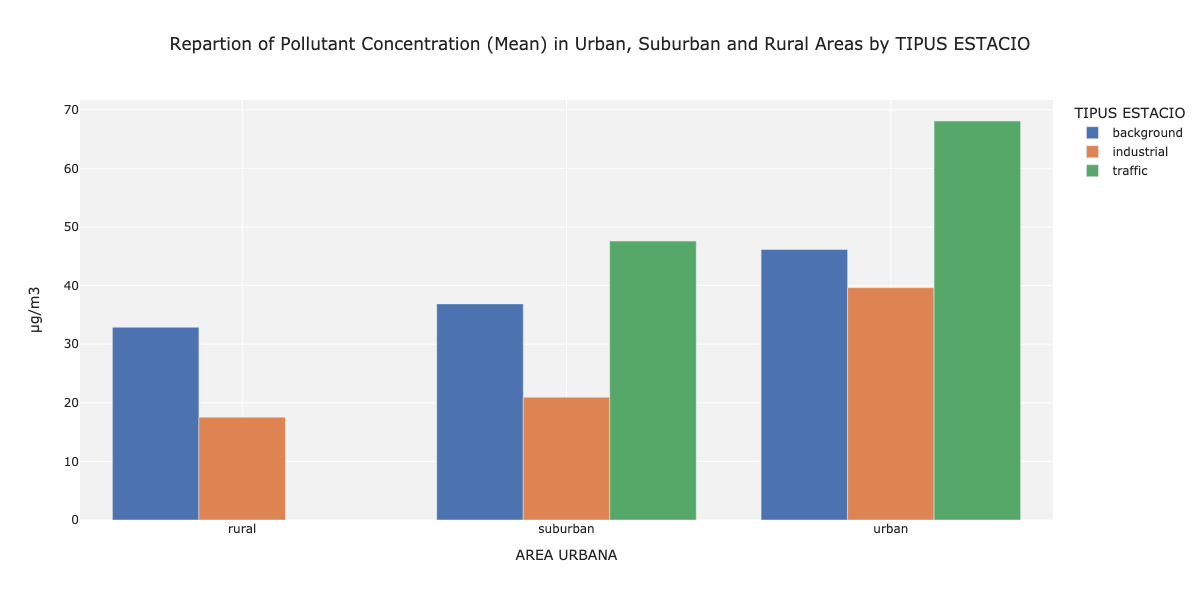

In [34]:
fig = px.bar(df_area_tipus_estacio, x="AREA URBANA", y="value", color="TIPUS ESTACIO", barmode='group', title="Repartion of Pollutant Concentration (Mean) in Urban, Suburban and Rural Areas by TIPUS ESTACIO")
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'})
fig.update_yaxes(title_text='µg/m3', col=1)
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [35]:
del df_area_tipus_estacio
gc.collect()

2475

In [36]:
dict_colors = dict(zip(df["TIPUS ESTACIO"].unique().tolist(), [colors[16], colors[0], colors[9]]))
dict_colors

{'industrial': '#BF5F37', 'background': '#4C72B0', 'traffic': '#4E9F67'}

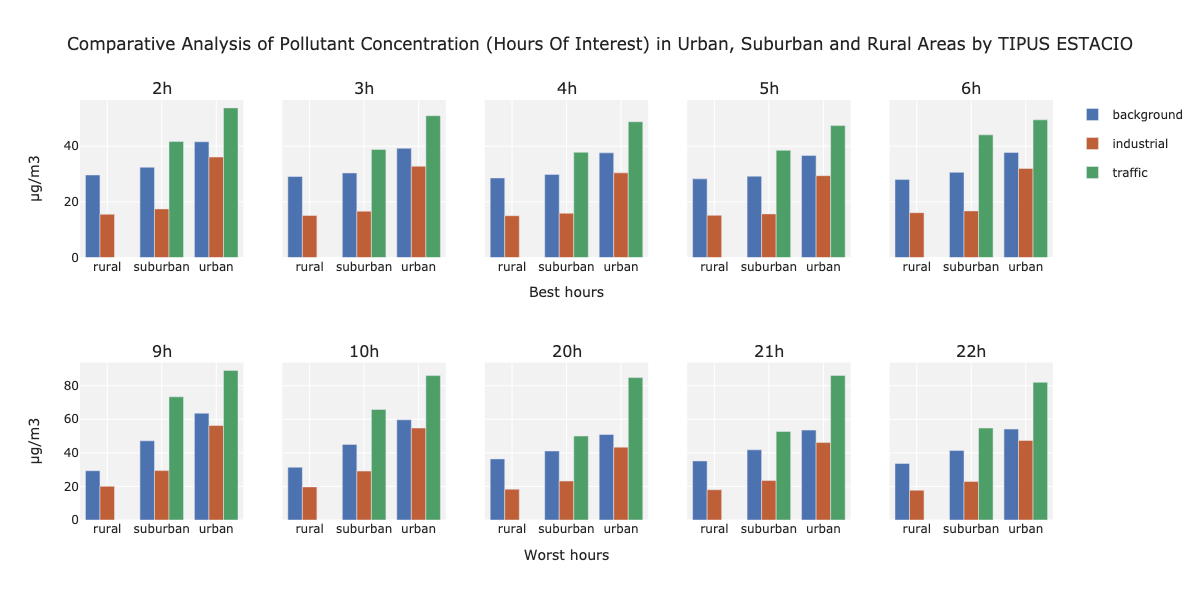

In [37]:
nrows = 2
ncols = 5
fig = make_subplots(rows=nrows, cols=ncols, shared_yaxes=True, subplot_titles=hours_of_interest_str)

df_area_by_hours = df.groupby(['AREA URBANA', "TIPUS ESTACIO", 'hour'], as_index=False).mean()

for i, h in enumerate(hours_of_interest):
    row = i // ncols + 1
    col = i % ncols + 1
    df_area_subset_hour = df_area_by_hours[df_area_by_hours['hour'] == h]

    df_grouped = df_area_subset_hour.groupby(['AREA URBANA', "TIPUS ESTACIO"]).sum().reset_index()

    for cont in df_grouped["TIPUS ESTACIO"].unique():
        df_cont = df_grouped[df_grouped["TIPUS ESTACIO"] == cont]
        fig.add_trace(go.Bar(x=df_cont['AREA URBANA'], y=df_cont['value'], name=cont, legendgroup=cont, marker_color=dict_colors[cont]), row=row, col=col)
    

names = set()
fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
fig.update_layout(barmode='group')
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'})
fig.update_layout(title={'text':'Comparative Analysis of Pollutant Concentration (Hours Of Interest) in Urban, Suburban and Rural Areas by TIPUS ESTACIO'})
fig.update_yaxes(title_text='µg/m3', col=1)
fig.update_xaxes(title_text='Best hours', row=1, col=3)
fig.update_xaxes(title_text='Worst hours', row=2, col=3)
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [38]:
del df_area_by_hours
gc.collect()

796

### 4. Rank the cities in the dataset according to their level of pollution, and create best-5 and worst-5 lists.

All cities on all areas

In [39]:
df_municipi = df.groupby('MUNICIPI', as_index=False).mean()

In [40]:
df_municipi.head()

,MUNICIPI,CODI EOI,ALTITUD,LATITUD,LONGITUD,hour,value,month,year
0,Agullana,17001002.0,214.0,42.392001,2.842100,12.504336,69.789998,6.626709,2017.751548
1,Alcanar,43004005.0,7.0,40.552807,0.530000,12.466101,7.291231,6.510919,2017.801069
2,Alcover,43005002.0,238.0,41.278687,1.179898,12.518199,49.210035,6.610949,2017.760901
3,"Ametlla de Mar, l'",43013002.0,34.0,40.902482,0.809721,12.491864,34.712456,6.642266,2017.717706
4,Amposta,43014001.0,8.0,40.706703,0.581701,12.502935,22.633435,6.629391,2017.709678


In [41]:
df_municipi_sorted = df_municipi.sort_values('value')

best_5  = df_municipi_sorted.head(5)
worst_5 = df_municipi_sorted.tail(5)

In [42]:
print(f"Best Cities : {best_5['MUNICIPI'].tolist()}")

Best Cities : ['Flix', 'Perafort', 'Alcanar', 'Cubelles', 'Sitges']


In [43]:
print(f"Worst Cities : {worst_5['MUNICIPI'].tolist()}")

Worst Cities : ['Agullana', 'Pardines', 'Girona', 'Sénia, la', 'Terrassa']


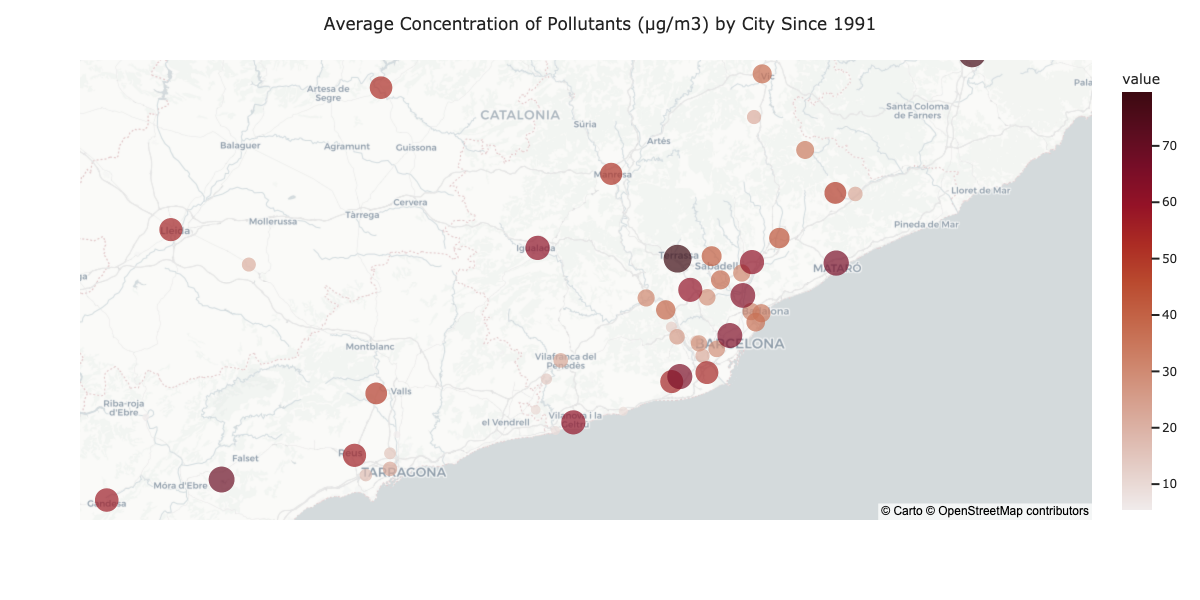

In [44]:
fig = px.scatter_mapbox(df_municipi_sorted, lat="LATITUD", lon="LONGITUD", hover_name="MUNICIPI", color="value", size='value',
                  color_continuous_scale=px.colors.sequential.amp, size_max=20, zoom=8,
                  mapbox_style="carto-positron")
fig.update_layout(title={'text':'Average Concentration of Pollutants (µg/m3) by City Since 1991'})
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [45]:
del df_municipi_sorted, df_municipi
gc.collect()

1271

Best/Worst cities on the Urban area

In [46]:
df_municipi_area = df.groupby(['MUNICIPI', 'AREA URBANA'], as_index=False).mean()
df_municipi_area_urban = df_municipi_area[df_municipi_area['AREA URBANA'] == 'urban']

In [47]:
df_municipi_area_urban.head()

,MUNICIPI,AREA URBANA,CODI EOI,ALTITUD,LATITUD,LONGITUD,hour,value,month,year
5,Badalona,urban,8.015021e+06,7.000000,41.443985,2.237899,12.498149,34.421019,6.642821,2017.631790
6,Barberà del Vallès,urban,8.252006e+06,131.000000,41.512683,2.125398,12.494196,37.790345,6.647082,2017.702357
8,Barcelona,urban,8.019044e+06,57.097373,41.396742,2.152857,12.502620,66.745487,6.605608,2017.834032
14,Cornellà de Llobregat,urban,8.073001e+06,27.000000,41.356380,2.076113,11.930693,21.458746,5.000000,2013.000000
19,Girona,urban,1.707900e+07,73.000000,41.976379,2.816500,12.503567,77.366466,6.636309,2017.953489


In [48]:
df_municipi_area_urban_sorted = df_municipi_area_urban.sort_values('value')

best_5 = df_municipi_area_urban_sorted.head(5)
worst_5 = df_municipi_area_urban_sorted.tail(5)

In [49]:
print(f"Best Cities : {best_5['MUNICIPI'].tolist()}")

Best Cities : ['Cornellà de Llobregat', 'Sant Cugat del Vallès', "Hospitalet de Llobregat, l'", 'Santa Coloma de Gramenet', 'Badalona']


In [50]:
print(f"Worst Cities : {worst_5['MUNICIPI'].tolist()}")

Worst Cities : ['Vilanova i la Geltrú', 'Mataró', 'Barcelona', 'Girona', 'Terrassa']


### Global evolution of polluants concentration

In [51]:
df_year = df.groupby(pd.Grouper(key="datetime", freq="YS")).mean()
df_year['datetime'] = df_year.index.get_level_values('datetime')
df_year = df_year.reset_index(drop=True)

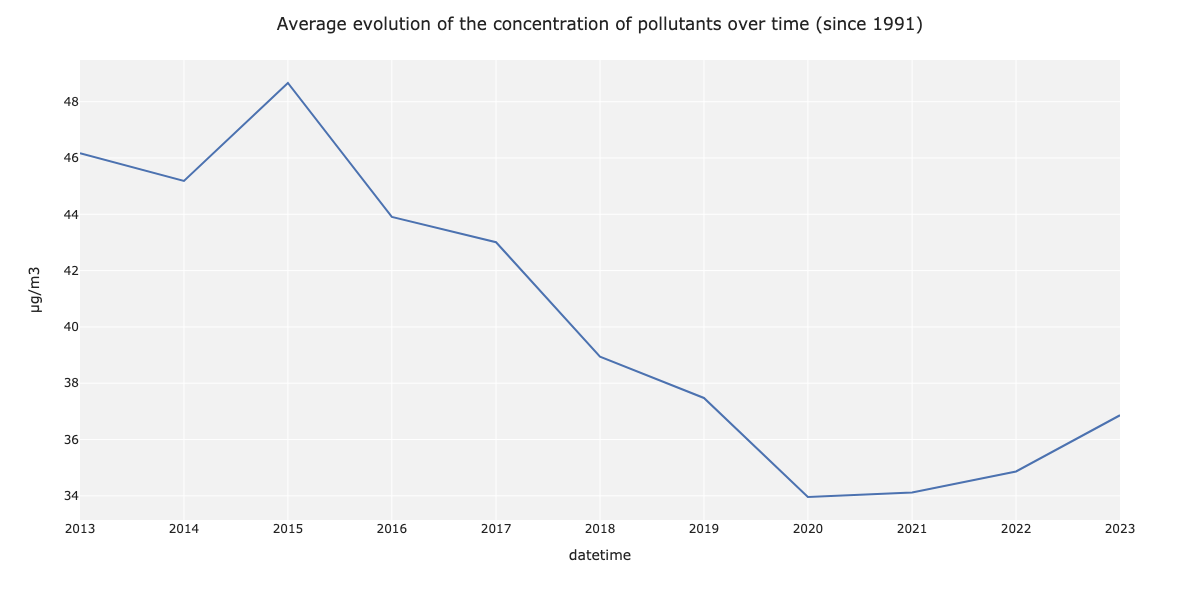

In [52]:
fig = px.line(df_year, x='datetime', y='value')
fig.update_layout(title={'text':'Average evolution of the concentration of pollutants over time (since 1991)'})
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0.05)'})
fig.update_yaxes(title_text='µg/m3', col=1)
# fig.show()
fig.update_layout(width=1200, height=600)
fig.show("png")

In [53]:
del df_year
gc.collect()

1383